# dependencies
* install anaconda is recommended

```
cassandra-driver          3.11.0                   py35_1    conda-forge
pandas                    0.19.1              np111py35_0
scikit-learn              0.18.1              np111py35_0
scipy                     0.18.1              np111py35_0
matplotlib                2.0.0               np111py35_0
```

In [5]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib
import time
import numpy as np
%matplotlib inline

import pandas as pd
pd.options.display.max_colwidth = 300
pd.options.display.max_columns = 100


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#Model File Directory
WORK_DIR = '/var/spark/ml_files/'

#Label Keys
LABEL = "success"

MODEL_TYPE = "ML-BPR"

start_date = '2019-01-01'
end_date = '2019-05-31'


In [7]:
# from cassandra
from cassandra.cluster import Cluster
cassandra_endpoint = '10.62.1.118'
cluster = Cluster([cassandra_endpoint])


In [10]:
TRAINING_DATA_PATH = WORK_DIR + 'processor_retry_2019_06.csv'
retry_success =  pd.read_csv(TRAINING_DATA_PATH)

retry_success.shape

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(96641, 57)

In [21]:
BIN_PROFILE_PATH = WORK_DIR + 'bin_profile_2019_01_to_2019_05.csv'
bin_profile = None
if BIN_PROFILE_PATH:
    bin_profile = pd.read_csv(BIN_PROFILE_PATH)
    bin_profile['bin'] = bin_profile['bin'].fillna('').astype(str).str.replace('.0', '', regex=False)
    bin_profile.shape

In [11]:
original_size = len(retry_success)
fail_size = retry_success[LABEL].value_counts(normalize=True)[0.0]
success_size =  retry_success[LABEL].value_counts(normalize=True)[1.0]

In [12]:
import numpy as np
from sklearn import cross_validation
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn import cross_validation
from sklearn import ensemble
from sklearn.dummy import DummyClassifier
# from sklearn.model_selection import GridSearchCV
from spark_sklearn import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

# from src.web.utils import PreProcessing
from src.web.preprocessing import PreProcessing
from src.web.encoder import EnhancedLeaveOneOutEncoder
from src.web.train_util import *

/opt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
INPUT_FEATURES = {
            "billing_country": {
                "type": "string"
            },
            "bin": {
                "type": "string"
            },
            "card_brand": {
                "type": "string"
            },
            "card_category": {
                "type": "string"
            },
            "card_class": {
                "type": "string"
            },
            "card_usage": {
                "type": "string"
            },
            "cc_expiration_date": {
                "type": "string"
            },
            "day_of_month": {
                "type": "integer"
            },
            "failed_attempt_date": {
                "type": "string"
            },
            "failed_response_code": {
                "type": "string"
            },
            "failed_response_message": {
                "type": "string"
            },
            "funding_source": {
                "type": "string"
            },
            "issuer_country": {
                "type": "string"
            },
            "merchant_number": {
                "type": "string"
            },
            "payment_amount_usd": {
                "type": "number"
            },
            "payment_currency": {
                "type": "string"
            },
            "payment_method_id": {
                "type": "string"
            },
            "payment_service_id": {
                "type": "string"
            },
            "renew_att_num": {
                "type": "integer"
            },
            "site_id": {
                "type": "string"
            },
            "transaction_date_in_string": {
                "type": "string"
            },
            "failed_cid": {
                "type": "string"
            },
            "failed_payment_service_id": {
                "type": "string"
            },
            "failed_merchant_number": {
                "type": "string"
            },
            "processor_att_num": {
                "type": "integer"
            },
            "merchant_descriptor": {
                "type": "integer"
            },
            "bank_name": {
                "type": "integer"
            } 
        }

In [23]:
PAYMENT_MID_BIN_PATH = WORK_DIR + 'payment_mid_bin_2019_01_to_05.csv'
payment_mid_bin_dict = None
if PAYMENT_MID_BIN_PATH:
    payment_mid_bin = pd.read_csv(PAYMENT_MID_BIN_PATH)
    payment_mid_bin['bin'] = payment_mid_bin['bin'].apply(str).str.replace('.0', '', regex=False)
    payment_mid_bin_dict = payment_mid_bin.set_index(['bin', 'payment_service_id', 'merchant_number'])['success_rate'].T.to_dict()


In [24]:
FEATURES_CAT = ["card_category", "issuer_country", "merchant_number", "merchant_descriptor", "bank_name", 
                "payment_service_id", "bin", "failed_merchant_number", "failed_payment_service_id", "payment_currency", 
                "day_of_month", "failed_response_code", "failed_decline_type", "transaction_hour", 'failed_cid']

FEATURES_NUM = ['payment_amount_usd']

FEATURES_FLOAT = ['bin', 'renew_att_num', 'failed_response_code']

FEATURES_NUM_CALCULATED = []
FEATURES_ENCODED = ['week_of_month', 'day_of_week', 'is_expired']
FEATURES_NUM_ENCODED = ['payment_mid_bin']
FEATURES = FEATURES_CAT + FEATURES_ENCODED

# from sklearn.model_selection import GridSearchCV
from spark_sklearn import GridSearchCV

# from training import PreProcessing
# from sklearn.pipeline import make_pipeline
from src.web.preprocessing import PreProcessing
from src.web.preprocessing import make_pipeline
from sklearn.preprocessing import Imputer

FIELDS = FEATURES_CAT + FEATURES_NUM + ['transaction_date_in_string', 'cc_expiration_date',  'failed_cc_expiration_date', 'billing_country']
df_decline_type = pd.read_csv(WORK_DIR + 'Decline_Type.csv')

features_dict = {'LABEL': LABEL, 'FIELDS': FIELDS ,'FEATURES_CAT': FEATURES_CAT, 'FEATURES_NUM':FEATURES_NUM, 'FEATURES_ENCODED':FEATURES_ENCODED, 'FEATURES_NUM_ENCODED':FEATURES_NUM_ENCODED, 'FEATURES_NUM_CALCULATED':FEATURES_NUM_CALCULATED, 'FEATURES_FLOAT': FEATURES_FLOAT}
features_dict_key = 'preprocessing__features_dict'
features_dict['df_bin_profile'] = bin_profile
features_dict['df_decline_type'] = df_decline_type
features_dict['payment_mid_bin_dict'] = payment_mid_bin_dict


--------------------
(9000, 20)
(9000,)
(1000, 20)
(1000,)
## bin_profile: (32843, 12)
# df_bin_profile: (32843, 12)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...
self.features_encoded: ['week_of_month', 'day_of_week', 'is_expired']
In fit, self.df_decline_type: (9395, 2)


/var/spark/jupyter-notebooks/src/web/preprocessing.py:231: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].fillna('').astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:237: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

# Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["payment_mid_bin"] = df.apply(self.payment_mid_bin_util.payment_mid_bin, axis=1)


self.features_all:  ['card_category', 'issuer_country', 'merchant_number', 'merchant_descriptor', 'bank_name', 'payment_service_id', 'bin', 'failed_merchant_number', 'failed_payment_service_id', 'payment_currency', 'day_of_month', 'failed_response_code', 'failed_decline_type', 'transaction_hour', 'failed_cid', 'week_of_month', 'day_of_week', 'is_expired', 'payment_amount_usd', 'payment_mid_bin']
In fit, self.features_cat_and_encoded: ['card_category', 'issuer_country', 'merchant_number', 'merchant_descriptor', 'bank_name', 'payment_service_id', 'bin', 'failed_merchant_number', 'failed_payment_service_id', 'payment_currency', 'day_of_month', 'failed_response_code', 'failed_decline_type', 'transaction_hour', 'failed_cid', 'week_of_month', 'day_of_week', 'is_expired']
['card_category', 'issuer_country', 'merchant_number', 'merchant_descriptor', 'bank_name', 'payment_service_id', 'bin', 'failed_merchant_number', 'failed_payment_service_id', 'payment_currency', 'day_of_month', 'failed_respo

/var/spark/jupyter-notebooks/src/web/preprocessing.py:360: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["merchant_number"] = df.apply(self.convert_mid, axis=1)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:363: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["failed_merchant_number"] = df.apply(self.convert_failed_mid, axis=1)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:231: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["payment_mid_bin"] = df.apply(self.payment_mid_bin_util.payment_mid_bin, axis=1)
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


# transform_time: 12.752689361572266
[02:25:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[02:25:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=5
[02:25:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=6
[02:25:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 12 pruned nodes, max_depth=5
[02:25:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[02:25:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 8 pruned nodes, max_depth=8
[02:25:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=6
[02:25:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 16 pr

[02:25:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[02:25:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 12 pruned nodes, max_depth=6
[02:25:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=7
[02:25:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 14 pruned nodes, max_depth=4
[02:25:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 14 pruned nodes, max_depth=6
[02:25:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 14 pruned nodes, max_depth=4
[02:25:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[02:25:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes, max_depth=5
[02:25:10] 

[02:25:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 26 pruned nodes, max_depth=1
[02:25:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:11] /work

[02:25:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 12 pruned nodes, max_depth=6
[02:25:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[02:25:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 14 pruned nodes, max_depth=4
[02:25:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[02:25:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:12] /wor

[02:25:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[02:25:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 16 pruned nodes, max_depth=3
[02:25:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:13] /work

[02:25:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 16 pruned nodes, max_depth=3
[02:25:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=6
[02:25:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[02:25:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:13] /wor

[02:25:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[02:25:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[02:25:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:14] /work

[02:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[02:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 10 pruned nodes, max_depth=4
[02:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:15] /work

[02:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=5
[02:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[02:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:15] /wor

[02:25:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 14 pruned nodes, max_depth=3
[02:25:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[02:25:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[02:25:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[02:25:16] /work

[02:25:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 20 pruned nodes, max_depth=1
[02:25:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[02:25:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[02:25:17] /work

[02:25:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 16 pruned nodes, max_depth=3
[02:25:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[02:25:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:18] /work

[02:25:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[02:25:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 18 pruned nodes, max_depth=2
[02:25:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[02:25:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[02:25:19] /work

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/var/spark/jupyter-notebooks/src/web/preprocessing.py:360: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["merchant_number"] = df.apply(self.convert_mid, axis=1)


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.15, 'max_depth': 10, 'min_child_weight': 6, 'silent': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'n_estimators': 1000, 'missing': -999, 'max_delta_step': 1, 'seed': 1337, 'gamma': 3}
x_train (9000, 24)
x_test (1000, 20)
x_train  .....           card_category issuer_country                       merchant_number  \
4896     Visa Platinum             BR  75FA81DE-5AC5-5DCF-E97C-8F80A08ADE1E   
4782      Visa Classic             US                               7236114   
1496      Visa Classic             US                               7236114   
1957      Visa Classic             US                               7236114   
9171  Visa Traditional             US                               7236114   

     merchant_descriptor                           bank_name  \
4896    DRI*Avast Brazil                Banco Itaucard, S.A.   
4782   DRI*Kaspersky Lab      PNC Bank, National Association   
1496  DRI*AVAST Software 

/var/spark/jupyter-notebooks/src/web/preprocessing.py:363: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["failed_merchant_number"] = df.apply(self.convert_failed_mid, axis=1)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:231: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].fillna('').astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:237: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

# Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["payment_mid_bin"] = df.apply(self.payment_mid_bin_util.payment_mid_bin, axis=1)
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


# transform_time: 2.659576416015625
# training time: 33.258158445358276
x_train:          card_category issuer_country                       merchant_number  \
4896     Visa Platinum             BR  75FA81DE-5AC5-5DCF-E97C-8F80A08ADE1E   
4782      Visa Classic             US                               7236114   
1496      Visa Classic             US                               7236114   
1957      Visa Classic             US                               7236114   
9171  Visa Traditional             US                               7236114   

     merchant_descriptor                           bank_name  \
4896    DRI*Avast Brazil                Banco Itaucard, S.A.   
4782   DRI*Kaspersky Lab      PNC Bank, National Association   
1496  DRI*AVAST Software           Navy Federal Credit Union   
1957  DRI*AVAST Software  Green Dot Bank DBA Bonneville Bank   
9171   DRI*Kaspersky Lab                   USAA Savings Bank   

     payment_service_id     bin failed_merchant_number  \
4

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


model_file is generated:  ['/var/spark/ml_files/models/ML-BPR-2.1.pkl']
result_dict:  {'hyper_params': {'objective': 'binary:logistic', 'learning_rate': 0.15, 'max_depth': 10, 'min_child_weight': 6, 'silent': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'n_estimators': 1000, 'missing': -999, 'max_delta_step': 1, 'seed': 1337, 'gamma': 3}, 'training_time': 33.258158445358276, 'accuracy_dummy': 0.968, 'train_accuracy': 0.9877777777777778, 'test_accuracy': 0.973, 'train_class_report': '             precision    recall  f1-score   support\n\n          0       0.99      1.00      0.99      8804\n          1       0.94      0.47      0.63       196\n\navg / total       0.99      0.99      0.99      9000\n', 'test_class_report': '             precision    recall  f1-score   support\n\n          0       0.97      1.00      0.99       968\n          1       1.00      0.16      0.27        32\n\navg / total       0.97      0.97      0.96      1000\n', 'feature_importance_columns': "Index(['fail

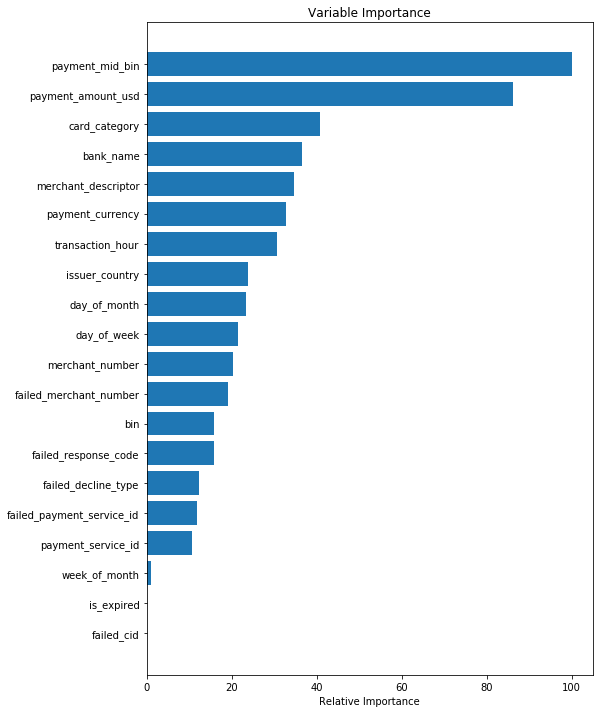

In [28]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = None

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.15, #0.1, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 6,
              'silent': 0,
              'subsample': 0.8,
              'colsample_bytree': 0.8, #0.8,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #500, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'max_delta_step': 1,
              'seed': 1337, 
              'gamma': 3 }

model_file = ''
model_id = 'ML-BPR-2'
version = get_latest_version(model_id, MODEL_TYPE) + 1
model_name = model_id + '.' + str(version)
features_dict['eval_metric'] = 'map'
xgb_clf, result_d = build_and_train(retry_success[:10000], classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters, features_dict=features_dict)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


In [29]:
result_d

{'hyper_params': {'objective': 'binary:logistic',
  'learning_rate': 0.15,
  'max_depth': 10,
  'min_child_weight': 6,
  'silent': 0,
  'subsample': 0.8,
  'colsample_bytree': 0.8,
  'n_estimators': 1000,
  'missing': -999,
  'max_delta_step': 1,
  'seed': 1337,
  'gamma': 3},
 'training_time': 33.258158445358276,
 'accuracy_dummy': 0.968,
 'train_accuracy': 0.9877777777777778,
 'test_accuracy': 0.973,
 'train_class_report': '             precision    recall  f1-score   support\n\n          0       0.99      1.00      0.99      8804\n          1       0.94      0.47      0.63       196\n\navg / total       0.99      0.99      0.99      9000\n',
 'test_class_report': '             precision    recall  f1-score   support\n\n          0       0.97      1.00      0.99       968\n          1       1.00      0.16      0.27        32\n\navg / total       0.97      0.97      0.96      1000\n',
 'feature_importance_columns': "Index(['failed_cid', 'is_expired', 'week_of_month', 'payment_service_

In [30]:
# """Upload model to Nexus repo and insert the model info into Cassandra table"""
# import json

# start_date = '2018-01-01'
# # start_date = '2019-01-01'
# # start_date = '2019-01-01'

# # end_date = '2019-03-31'
# end_date = '2019-05-31'


# try:
#     repo_path = upload_artifact(model_file_name)
#     preprocess_repo_path = handle_preprocessing_file(model_id, version)
#     size_desc = str(", original size: %s (fail: %s, success: %s), balanced_size: %s" % (original_size, fail_size, success_size, original_size))
#     desc = '{}_{}_for_processor retry model. {}'.format(start_date, end_date, size_desc)
#     hyper_params = result_d.pop('hyper_params', None)
#     extended_att = {"preprocess_repo_path": preprocess_repo_path, "input_features": INPUT_FEATURES}
#     insert_model_info(model_id, version, repo_path, desc=desc, model_type=MODEL_TYPE,eval_metrics=json.dumps(result_d), 
#                       hyper_parameter=json.dumps(hyper_params), extended_att=json.dumps(extended_att), features_dict=features_dict)
    
# except:
#     if not hyper_params:
#         result_d['hyper_params'] = hyper_params 

http://10.48.48.10/nexus/content/repositories/foundationreleases/com/digitalriver/prediction-service/ML-BPR/2.1/ML-BPR-2.1.pkl
[com.digitalriver.prediction-service:ML-BPR:2.1::pkl]
http://10.48.48.10/nexus/content/repositories/foundationreleases/com/digitalriver/prediction-service/ML-BPR/2_1_preprocessing/ML-BPR-2_1_preprocessing.py
[com.digitalriver.prediction-service:ML-BPR:2_1_preprocessing::py]
Model ML-BPR-2 version 1 is inserted into model repo


The following files were uploaded to repository foundationreleases
The following files were uploaded to repository foundationreleases
